## 1. Preparing the dataset

Goal:



In [82]:
import pickle
import pandas as pd 

with open('datas.p', 'rb') as file:
    data = pickle.load(file)

In [83]:
reformatted = []

for record in data:
    
    new_record = {
        'station': record['station'],
        'time': record['time'],
        'parameter': record['parameter'],
        'value': record['value']
        }
    reformatted.append(new_record)


In [84]:
df = pd.DataFrame(reformatted)


In [85]:
shit = 0
for i in reformatted:
    if i['value']<0:
        shit+=1

print(shit)

12373


In [86]:
wide_df = df.pivot_table(
    index=['station', 'time'], 
    columns='parameter', 
    values='value'
).reset_index()

print(wide_df.head())


parameter          station                  time   no2    o3  pm25
0          Barnsley Gawber  2022-07-17T00:00:00Z  12.0  68.0   NaN
1          Barnsley Gawber  2022-07-17T01:00:00Z  14.0  59.0   NaN
2          Barnsley Gawber  2022-07-17T02:00:00Z  11.0  53.0   NaN
3          Barnsley Gawber  2022-07-17T03:00:00Z  19.0  47.0   NaN
4          Barnsley Gawber  2022-07-17T04:00:00Z  13.0  42.0   NaN


In [87]:
len(wide_df)

1440415

In [88]:
wide_df.isna().sum()

parameter
station         0
time            0
no2         79625
o3         181558
pm25       261053
dtype: int64

There is a lot of missing entires here, this usually happens when the station is on maintainance or a station had an outdated monitor and they decided to upgrade to a newer one which can detect more particles. Moreover, the more important point is that there is only so much imputation can do, therefore I will have to decide whether to remove an entire station or not.

Though there is no rush to remove an entire station... It's always nice to have extra data, however it's not worth it when the imputation ends up tainting our data.


In [89]:
product = ['no2', 'pm25', 'o3']
import numpy as np
for col in product:
    wide_df.loc[wide_df[col]< 0, col] = np.nan

It was realised that there was negative values in the data 😢 which is incredibly annoying, It is in fact impossible to have negative recordings. I'm going to mark them was NaN for now, I will have to impute this stuff as well. 

In [90]:
wide_df.isna().sum()

parameter
station         0
time            0
no2         85179
o3         187184
pm25       262246
dtype: int64

In [91]:
unique_stations = wide_df['station'].unique()
pd.set_option('display.max_rows', None)

for k in product:
    print('#'*100)
    print('#'*100)
    print(f'Description of {k}')
    a = wide_df.groupby('station')[k].describe()
    print(a)
pd.set_option('display.max_rows', 10)

####################################################################################################
####################################################################################################
Description of no2
                                      count       mean        std       min  \
station                                                                       
Barnsley Gawber                     19428.0  11.578057   9.997836   0.00000   
Belfast Centre                      19274.0  18.683053  15.064624   0.00000   
Bexley - Belvedere West             19733.0  13.413673  11.806281   0.00000   
Bexley - Slade Green Fidas          20439.0  16.411435  14.398817   0.00000   
Birmingham A4540 Roadside           19499.0  29.022847  16.343911   2.00000   
Blackpool Marton                    19465.0   8.221302   8.200364   0.00000   
Bournemouth                         18611.0   7.714276   7.999537   0.00000   
Brent - Ikea                        17757.0  35.229830  19.802892   

In [92]:
wide_df.head(5)

parameter,station,time,no2,o3,pm25
0,Barnsley Gawber,2022-07-17T00:00:00Z,12.0,68.0,NaN
1,Barnsley Gawber,2022-07-17T01:00:00Z,14.0,59.0,NaN
2,Barnsley Gawber,2022-07-17T02:00:00Z,11.0,53.0,NaN
3,Barnsley Gawber,2022-07-17T03:00:00Z,19.0,47.0,NaN
4,Barnsley Gawber,2022-07-17T04:00:00Z,13.0,42.0,NaN


Text(0, 0.5, 'Stations')

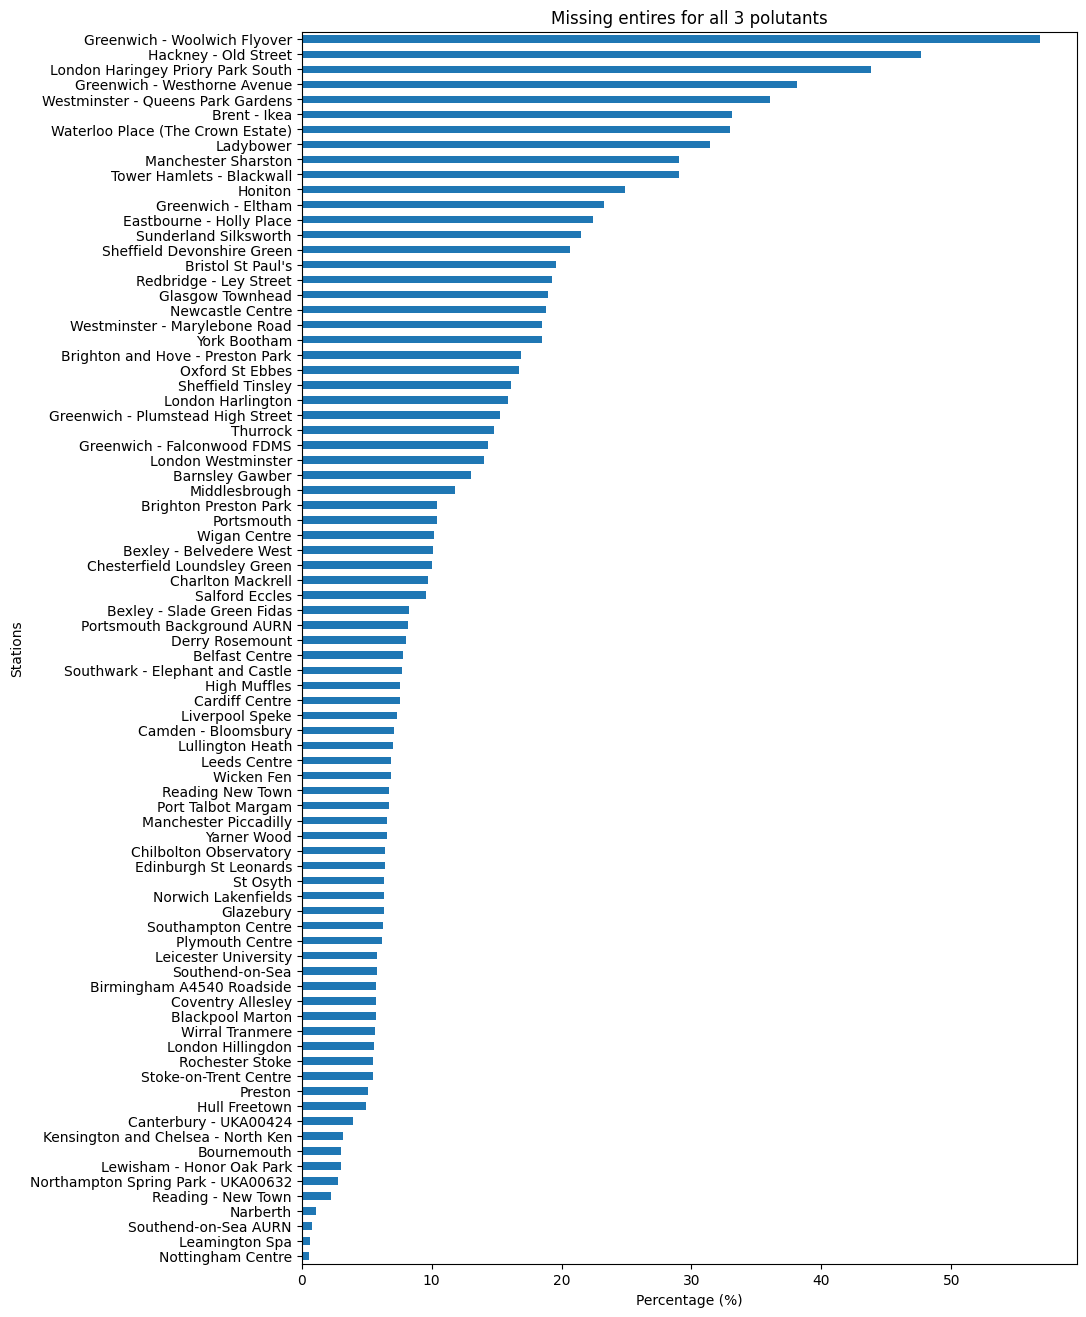

In [93]:
import matplotlib.pyplot as plt 

unique_stations = wide_df['station'].unique()
missing_stats = wide_df.groupby('station')[product].apply(lambda x: x.isna().sum()).sum(axis=1)
total_cell = wide_df.groupby('station').size() * len(product)

plt.figure(figsize=(10, 16))
total_count = wide_df.groupby('station').size()
percent_miss = (missing_stats/total_cell)*100
percent_miss.sort_values().plot(kind='barh')
plt.title('Missing entires for all 3 polutants')
plt.xlabel('Percentage (%)')
plt.ylabel('Stations')

Will need to think of a threshold for the stations, Greenwich - Woolwich flyover will need to be removed because it has over 50% of entries missing which is quite concerning. There is no point imputing when there is this much data missing.

Next, we ask ourselves - is there a certain period for each station where there is a lot of data missing?


In [94]:

a = percent_miss[percent_miss > 40].index.tolist()

wide_df_cleaned = wide_df[~wide_df['station'].isin(a)]


In [95]:
wide_df_cleaned.head(5)

parameter,station,time,no2,o3,pm25
0,Barnsley Gawber,2022-07-17T00:00:00Z,12.0,68.0,NaN
1,Barnsley Gawber,2022-07-17T01:00:00Z,14.0,59.0,NaN
2,Barnsley Gawber,2022-07-17T02:00:00Z,11.0,53.0,NaN
3,Barnsley Gawber,2022-07-17T03:00:00Z,19.0,47.0,NaN
4,Barnsley Gawber,2022-07-17T04:00:00Z,13.0,42.0,NaN


Text(0, 0.5, 'Stations')

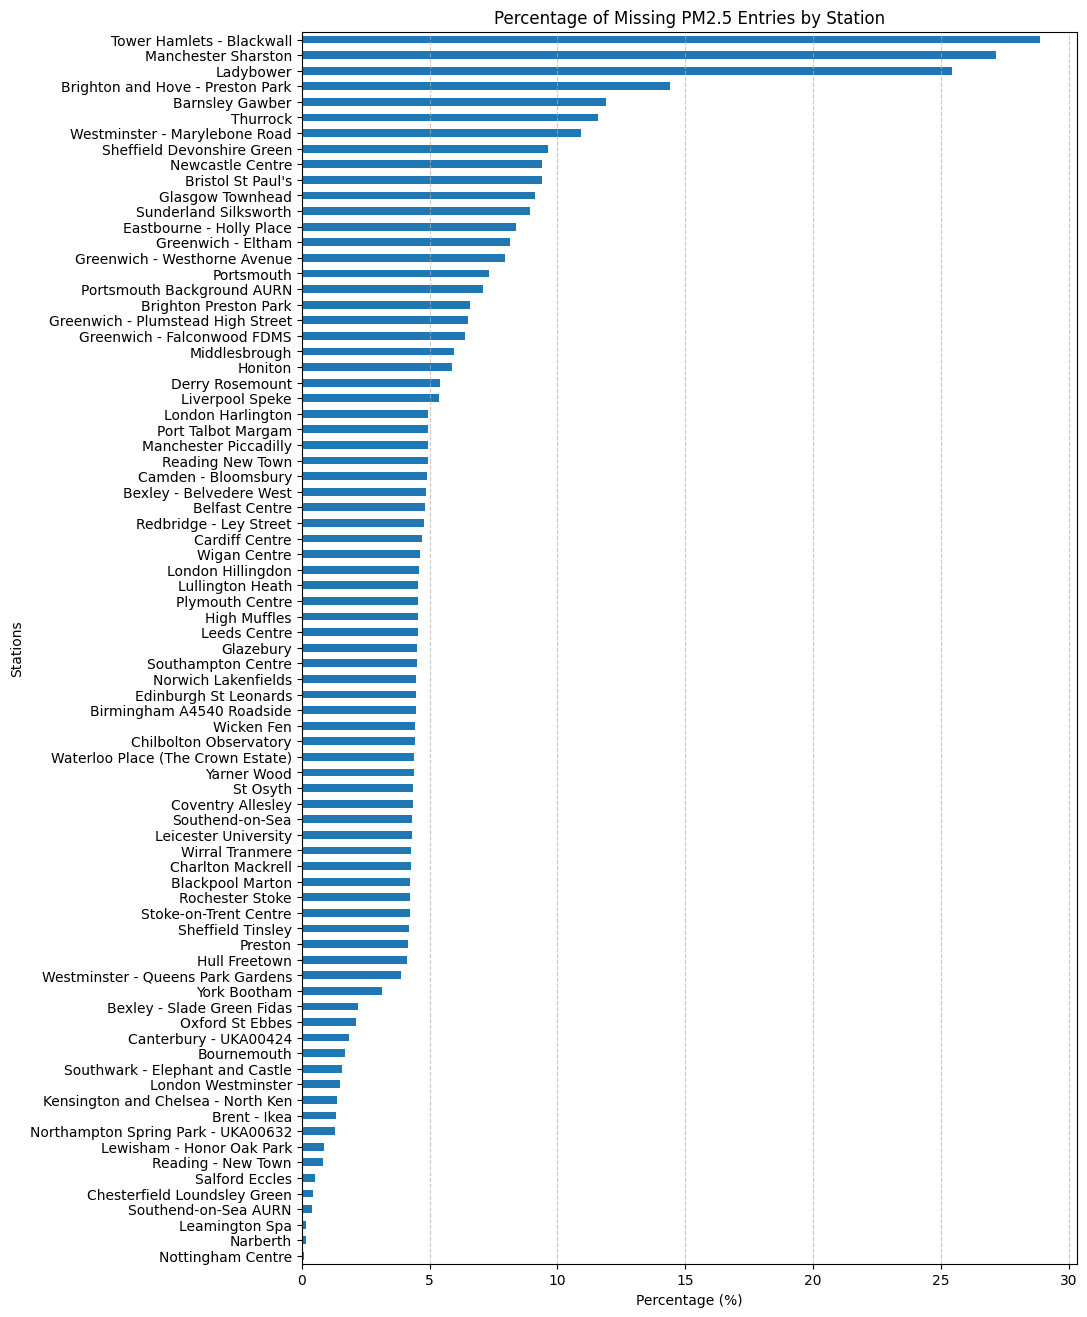

In [96]:
import matplotlib.pyplot as plt 

unique_stations = wide_df_cleaned['station'].unique()
missing_stats = wide_df_cleaned.groupby('station')['pm25'].apply(lambda x: x.isna().sum())
total_cell = wide_df_cleaned.groupby('station').size() * len(product)

plt.figure(figsize=(10, 16))
total_count = wide_df_cleaned.groupby('station').size()
percent_miss = (missing_stats/total_cell)*100
percent_miss.sort_values().plot(kind='barh')
plt.title('Percentage of Missing PM2.5 Entries by Station')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xlabel('Percentage (%)')
plt.ylabel('Stations')

In [97]:
a = percent_miss[percent_miss > 10].index.tolist()
wide_df_cleaned = wide_df_cleaned[~wide_df_cleaned['station'].isin(a)]
wide_df_cleaned.head(10)

parameter,station,time,no2,o3,pm25
19699,Belfast Centre,2022-07-17T00:00:00Z,14.0,43.0,7.0
19700,Belfast Centre,2022-07-17T01:00:00Z,16.0,40.0,7.0
19701,Belfast Centre,2022-07-17T02:00:00Z,17.0,39.0,7.0
19702,Belfast Centre,2022-07-17T03:00:00Z,17.0,39.0,7.0
19703,Belfast Centre,2022-07-17T04:00:00Z,9.0,40.0,7.0
19704,Belfast Centre,2022-07-17T05:00:00Z,12.0,41.0,7.0
19705,Belfast Centre,2022-07-17T06:00:00Z,12.0,40.0,8.0
19706,Belfast Centre,2022-07-17T07:00:00Z,15.0,38.0,8.0
19707,Belfast Centre,2022-07-17T08:00:00Z,11.0,38.0,8.0
19708,Belfast Centre,2022-07-17T09:00:00Z,6.0,40.0,8.0


As annoying as thing is, we will have to be quite strict with the removal here. Reason being is that these missing entires are in fact a continuous missing entries, so for example Barnsley would have 4 months worth of missing data consecutively which is something even imputation will struggle to fix. We will have to completely remove the station here.

In [98]:
wide_df_cleaned.sample(10)

parameter,station,time,no2,o3,pm25
409377,Glazebury,2022-11-07T11:00:00Z,5.0000,57.00000,5.0
575453,Hull Freetown,2025-03-09T02:00:00Z,18.7425,30.13507,NaN
214351,Camden - Bloomsbury,2023-08-06T09:00:00Z,21.0000,36.00000,3.0
785545,London Westminster,2024-06-19T16:00:00Z,11.0000,54.00000,7.0
642232,Leeds Centre,2023-08-15T10:00:00Z,12.0000,48.00000,3.0
582059,Kensington and Chelsea - North Ken,2023-01-16T00:00:00Z,15.9000,51.70000,NaN
832172,Manchester Piccadilly,2025-06-29T18:00:00Z,13.0000,49.00000,6.0
1382314,Wirral Tranmere,2022-07-27T23:00:00Z,19.0000,50.00000,3.0
420361,Glazebury,2024-07-16T11:00:00Z,3.0000,53.00000,4.0
435465,Greenwich - Falconwood FDMS,2022-09-16T02:00:00Z,19.1000,28.00000,3.3


In [99]:
wide_df_cleaned.isna().sum()

parameter
station         0
time            0
no2         78236
o3         154823
pm25       171241
dtype: int64

In [100]:
wide_df_cleaned = wide_df_cleaned.reset_index()

In [101]:
other = pd.read_csv('ff.csv')

In [102]:
other.head(5)

,date,station,wind_speed_10m,wind_direction_10m,temperature_2m,relative_humidity_2m,precipitation,rain,surface_pressure,pressure_msl,shortwave_radiation
0,2022-07-14 00:00:00+00:00,London Harlington,7.653705,48.814175,16.172,91.417070,0.0,0.0,1018.74786,1022.0,0.0
1,2022-07-14 01:00:00+00:00,London Harlington,6.989935,11.888645,15.572,95.604000,0.0,0.0,1018.74120,1022.0,0.0
2,2022-07-14 02:00:00+00:00,London Harlington,5.760000,360.000000,14.772,94.652200,0.0,0.0,1018.73224,1022.0,0.0
3,2022-07-14 03:00:00+00:00,London Harlington,7.771331,346.607480,14.522,81.120895,0.0,0.0,1018.92870,1022.2,0.0
4,2022-07-14 04:00:00+00:00,London Harlington,9.178235,348.690100,14.122,72.601310,0.0,0.0,1018.82450,1022.1,0.0


In [103]:
wide_df_cleaned.head(5)

parameter,index,station,time,no2,o3,pm25
0,19699,Belfast Centre,2022-07-17T00:00:00Z,14.0,43.0,7.0
1,19700,Belfast Centre,2022-07-17T01:00:00Z,16.0,40.0,7.0
2,19701,Belfast Centre,2022-07-17T02:00:00Z,17.0,39.0,7.0
3,19702,Belfast Centre,2022-07-17T03:00:00Z,17.0,39.0,7.0
4,19703,Belfast Centre,2022-07-17T04:00:00Z,9.0,40.0,7.0


In [104]:
wide_df.head(5)

parameter,station,time,no2,o3,pm25
0,Barnsley Gawber,2022-07-17T00:00:00Z,12.0,68.0,NaN
1,Barnsley Gawber,2022-07-17T01:00:00Z,14.0,59.0,NaN
2,Barnsley Gawber,2022-07-17T02:00:00Z,11.0,53.0,NaN
3,Barnsley Gawber,2022-07-17T03:00:00Z,19.0,47.0,NaN
4,Barnsley Gawber,2022-07-17T04:00:00Z,13.0,42.0,NaN


In [105]:
imputed_df = wide_df_cleaned.reset_index()


In [106]:
imputed_df

parameter,level_0,index,station,time,no2,o3,pm25
0,0,19699,Belfast Centre,2022-07-17T00:00:00Z,14.0,43.0,7.0
1,1,19700,Belfast Centre,2022-07-17T01:00:00Z,16.0,40.0,7.0
2,2,19701,Belfast Centre,2022-07-17T02:00:00Z,17.0,39.0,7.0
3,3,19702,Belfast Centre,2022-07-17T03:00:00Z,17.0,39.0,7.0
4,4,19703,Belfast Centre,2022-07-17T04:00:00Z,9.0,40.0,7.0
...,...,...,...,...,...,...,...
1289950,1289950,1440410,York Bootham,2025-07-15T11:00:00Z,NaN,38.0,NaN
1289951,1289951,1440411,York Bootham,2025-07-15T12:00:00Z,NaN,38.0,NaN
1289952,1289952,1440412,York Bootham,2025-07-15T13:00:00Z,NaN,35.0,NaN
1289953,1289953,1440413,York Bootham,2025-07-15T14:00:00Z,NaN,35.0,NaN


In [107]:
other.head(20)

,date,station,wind_speed_10m,wind_direction_10m,temperature_2m,relative_humidity_2m,precipitation,rain,surface_pressure,pressure_msl,shortwave_radiation
0,2022-07-14 00:00:00+00:00,London Harlington,7.653705,48.814175,16.172000,91.417070,0.0,0.0,1018.74786,1022.0,0.0
1,2022-07-14 01:00:00+00:00,London Harlington,6.989935,11.888645,15.572000,95.604000,0.0,0.0,1018.74120,1022.0,0.0
2,2022-07-14 02:00:00+00:00,London Harlington,5.760000,360.000000,14.772000,94.652200,0.0,0.0,1018.73224,1022.0,0.0
3,2022-07-14 03:00:00+00:00,London Harlington,7.771331,346.607480,14.522000,81.120895,0.0,0.0,1018.92870,1022.2,0.0
4,2022-07-14 04:00:00+00:00,London Harlington,9.178235,348.690100,14.122000,72.601310,0.0,0.0,1018.82450,1022.1,0.0
...,...,...,...,...,...,...,...,...,...,...,...
15,2022-07-14 15:00:00+00:00,London Harlington,12.783802,327.652600,23.272001,39.471752,0.0,0.0,1019.62330,1022.8,504.0
16,2022-07-14 16:00:00+00:00,London Harlington,17.102840,329.656830,23.422000,37.050926,0.0,0.0,1019.62490,1022.8,470.0
17,2022-07-14 17:00:00+00:00,London Harlington,20.056877,338.962400,22.072000,38.997340,0.0,0.0,1019.80950,1023.0,388.0
18,2022-07-14 18:00:00+00:00,London Harlington,16.622490,342.349760,21.522001,38.179650,0.0,0.0,1019.90344,1023.1,279.0


In [108]:
other.rename(columns={'date': 'time'}, inplace=True)
imputed_df['time'] = pd.to_datetime(imputed_df['time'])
other['time'] = pd.to_datetime(other['time'])
result = pd.merge(imputed_df, other, on=['time', 'station'], how='left')
result.drop(columns=['index', 'level_0'], errors='ignore', inplace=True)
result

,station,time,no2,o3,pm25,wind_speed_10m,wind_direction_10m,temperature_2m,relative_humidity_2m,precipitation,rain,surface_pressure,pressure_msl,shortwave_radiation
0,Belfast Centre,2022-07-17 00:00:00+00:00,14.0,43.0,7.0,5.154415,114.775116,14.488000,86.647680,0.0,0.0,1019.81600,1025.4,0.0
1,Belfast Centre,2022-07-17 01:00:00+00:00,16.0,40.0,7.0,4.680000,112.619910,13.938001,84.056150,0.0,0.0,1019.50710,1025.1,0.0
2,Belfast Centre,2022-07-17 02:00:00+00:00,17.0,39.0,7.0,6.439876,153.435010,14.438001,78.723180,0.0,0.0,1019.61600,1025.2,0.0
3,Belfast Centre,2022-07-17 03:00:00+00:00,17.0,39.0,7.0,7.172949,197.525670,14.888001,77.751450,1.1,1.1,1019.72420,1025.3,0.0
4,Belfast Centre,2022-07-17 04:00:00+00:00,9.0,40.0,7.0,5.623380,140.194470,14.888001,81.976660,1.3,1.3,1019.02790,1024.6,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1289950,York Bootham,2025-07-15 11:00:00+00:00,NaN,38.0,NaN,15.137133,177.273740,16.161001,80.542470,1.1,1.1,1008.41260,1010.2,188.0
1289951,York Bootham,2025-07-15 12:00:00+00:00,NaN,38.0,NaN,18.643690,169.992080,16.811000,76.275190,0.3,0.3,1008.01746,1009.8,137.0
1289952,York Bootham,2025-07-15 13:00:00+00:00,NaN,35.0,NaN,22.528780,172.193700,15.361000,92.257970,1.6,1.6,1008.10810,1009.9,164.0
1289953,York Bootham,2025-07-15 14:00:00+00:00,NaN,35.0,NaN,24.332644,177.031830,15.111000,91.052956,1.0,1.0,1007.70720,1009.5,98.0


In [109]:
result.isna().sum()

station                     0
time                        0
no2                     78236
o3                     154823
pm25                   171241
                        ...  
precipitation               0
rain                        0
surface_pressure            0
pressure_msl                0
shortwave_radiation         0
Length: 14, dtype: int64

In [110]:
len(result)

1289955

In [111]:
result.to_csv('weather_completed.csv', index=False)